In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import r2_score

sns.set(context='talk')


# this is horrible voodoo to get deprecation warnings to stop
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn



# a function to get predictions so we can plot true mullen vs predicted mullen
def get_held_outpredictions(X, estimators, splits):
    y_est = np.zeros(len(X))
    for i, (train_inds, test_inds) in enumerate(splits):
        estimator = estimators[i]
        y_est[test_inds] = estimator.predict(pd.DataFrame(X[test_inds, :]))
    return y_est

# function to scatter plot the true mullens vs estimates
def plot_scatter(y_true, y_est, months, model):
    plt.figure(figsize=(12, 12))
    straight_line = np.linspace(y_true.min() * 0.95, y_true.max() * 1.05, 100)
    plt.plot(straight_line, straight_line, alpha=0.25, c='r')
    plt.scatter(y_true, y_est, alpha=0.75)
    plt.xlabel('Average Raw Mullen Score')
    plt.ylabel('Predicted Average Raw Mullen Score')
    plt.xlim(y_true.min() * 0.95, y_true.max() * 1.05)
    plt.ylim(y_true.min() * 0.95, y_true.max() * 1.05)
    plt.title(f'Model = {model}, Months = {months}, R^2 = {np.round(r2_score(y_true, y_est), 3)}')

# load data
with open('data/processed_data.pickle', 'rb') as f:
    df_6m, input_covariates_6m, df_24m, input_covariates_24m = pickle.load(f)
    X_6m = df_6m[input_covariates_6m].values
    y_6m_raw = df_6m['mullen_6m_raw_average'].values
    X_24m = df_24m[input_covariates_24m].values
    y_24m_raw = df_24m['mullen_24m_raw_average'].values
    
# load results and models
with open('data/ml_results_raw.pickle', 'rb') as f:
    raw_6m_results, raw_6m_outer_cv, raw_24m_results, raw_24m_outer_cv = pickle.load(f)

In [2]:
# plot a table of the machine learning results
test_scores_mean = []
test_scores_std = []
model_names = []
months = []
for model_name, results in raw_6m_results.items():
    test_scores_mean.append(np.round(-results['test_score'].mean(), 2))
    test_scores_std.append(np.round(results['test_score'].std(), 2))
    model_names.append(model_name)
    months.append(6)
    
for model_name, results in raw_24m_results.items():
    test_scores_mean.append(np.round(-results['test_score'].mean(), 2))
    test_scores_std.append(np.round(results['test_score'].std(), 2))
    model_names.append(model_name)
    months.append(24)
    
df_test_scores = pd.DataFrame(
    {
        'Mullen Measurement Month': months,
        'Model Name': model_names,
        'Mean Absolute Error (average over folds)': test_scores_mean, 
        'Mean Absolute Error (standard deviation over folds)': test_scores_std,
    }
)

df_test_scores

,Mullen Measurement Month,Model Name,Mean Absolute Error (average over folds),Mean Absolute Error (standard deviation over folds)
0,6,Constant Regressor,0.48,0.08
1,6,Ridge Regression,0.49,0.07
2,6,ElasticNet,0.49,0.06
3,6,Support Vector Regression,0.49,0.08
4,6,LightGBM,0.49,0.10
5,6,AutoGluon,0.46,0.09
6,24,Constant Regressor,1.73,0.22
7,24,Ridge Regression,1.70,0.20
8,24,ElasticNet,1.68,0.22
9,24,Support Vector Regression,1.72,0.23


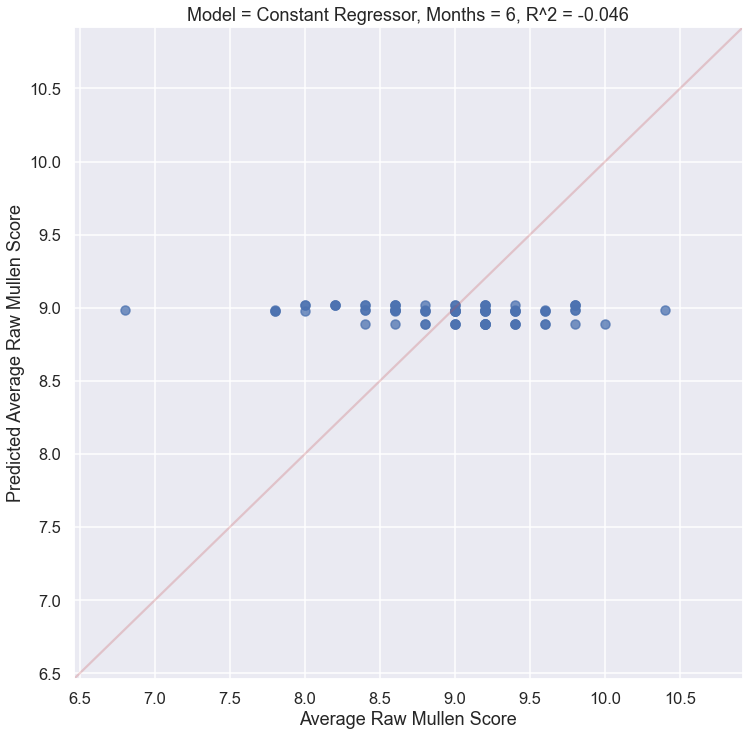

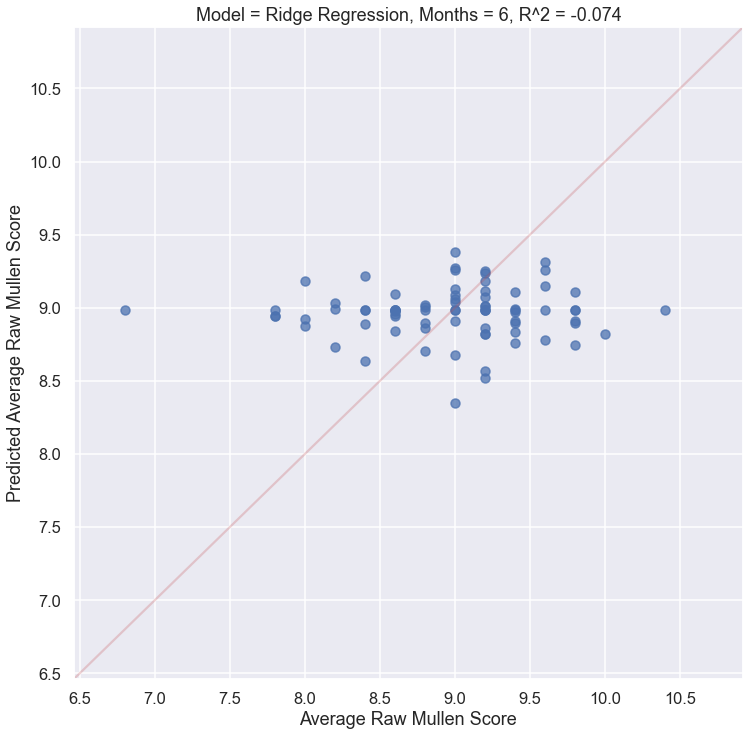

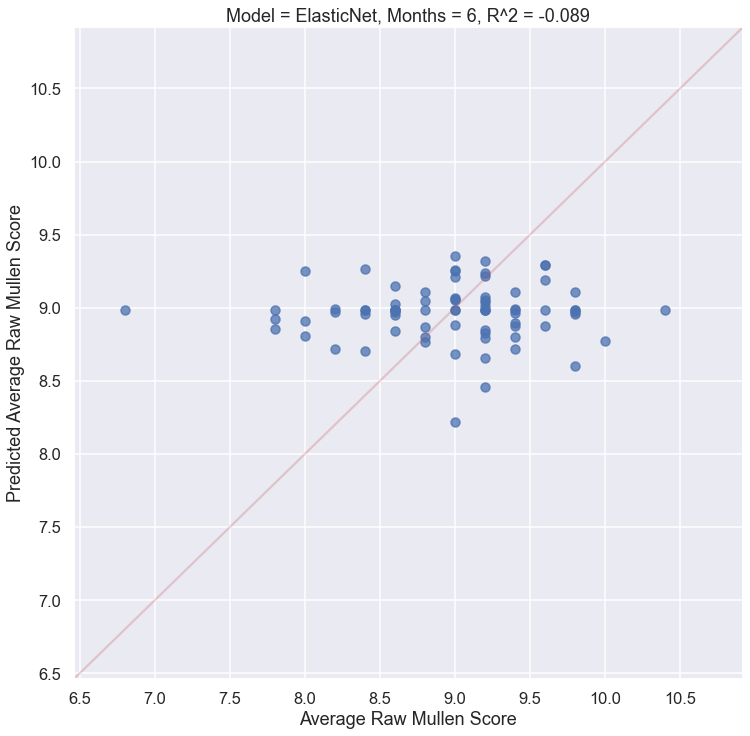

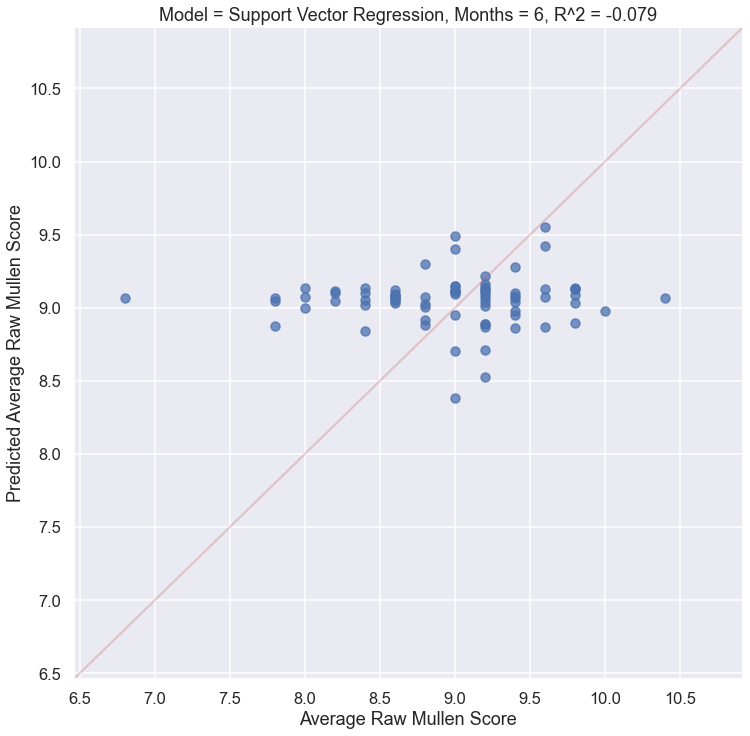

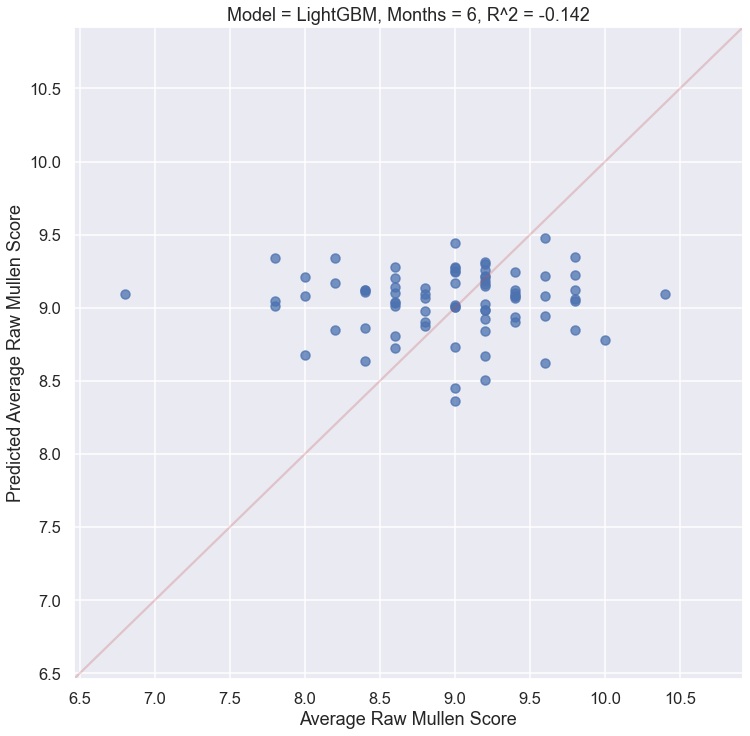

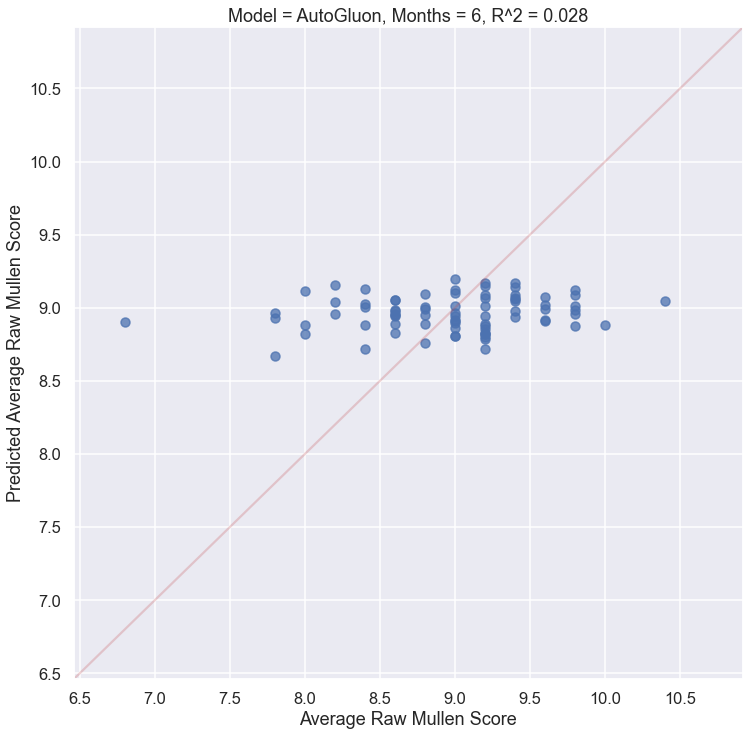

In [3]:
# plot scatter plots for 6m machine learning models models
for model_name, results in raw_6m_results.items():
    y_est = get_held_outpredictions(X_6m, results['estimator'], raw_6m_outer_cv)
    plot_scatter(y_6m_raw, y_est, 6, model_name)

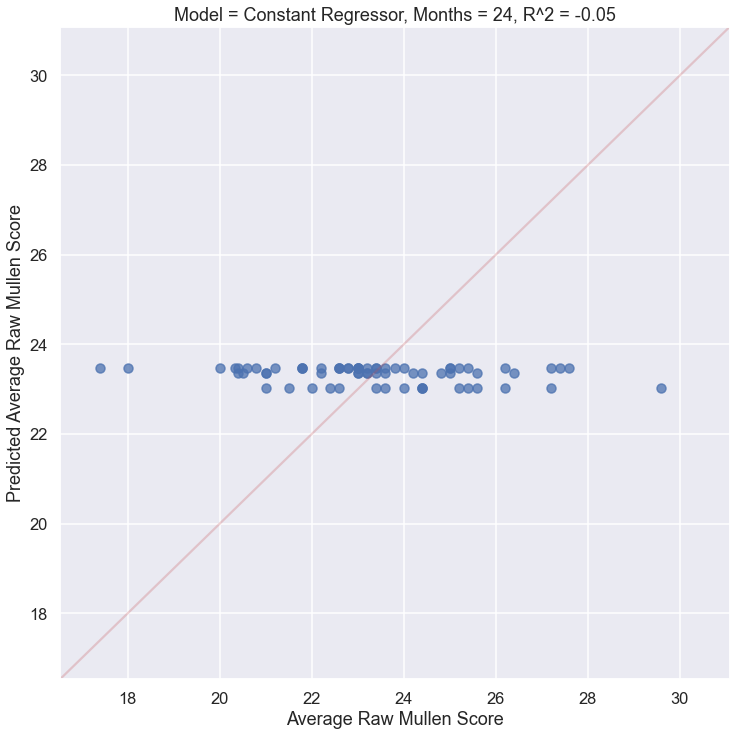

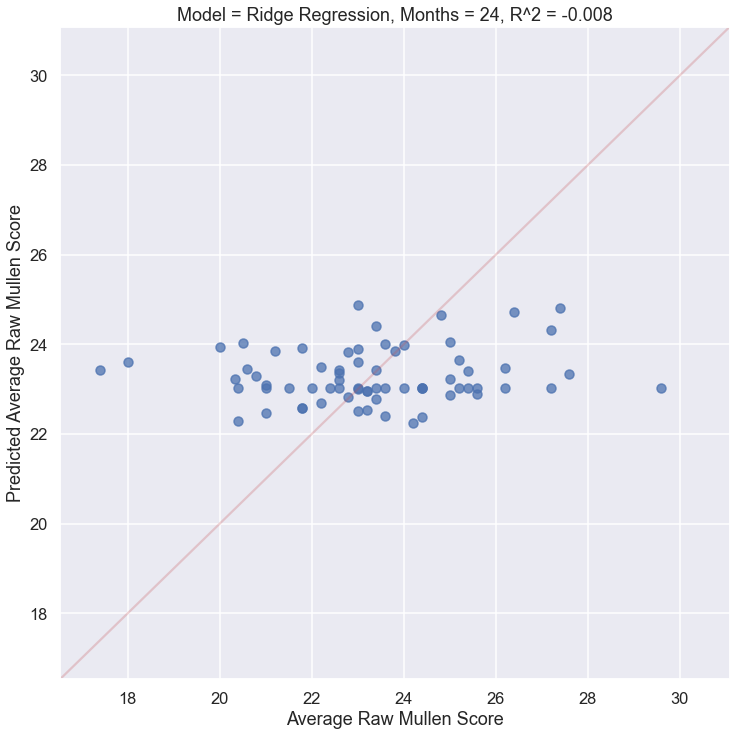

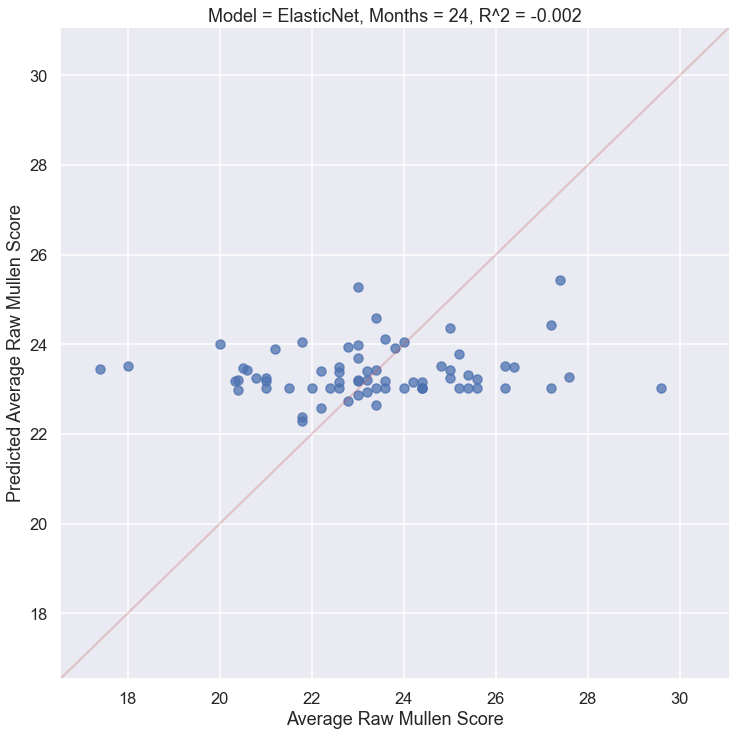

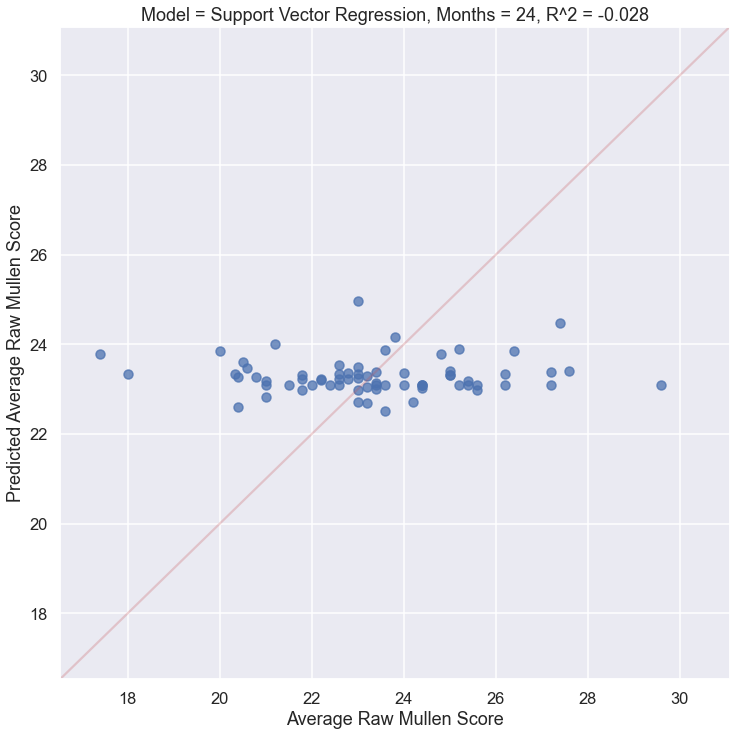

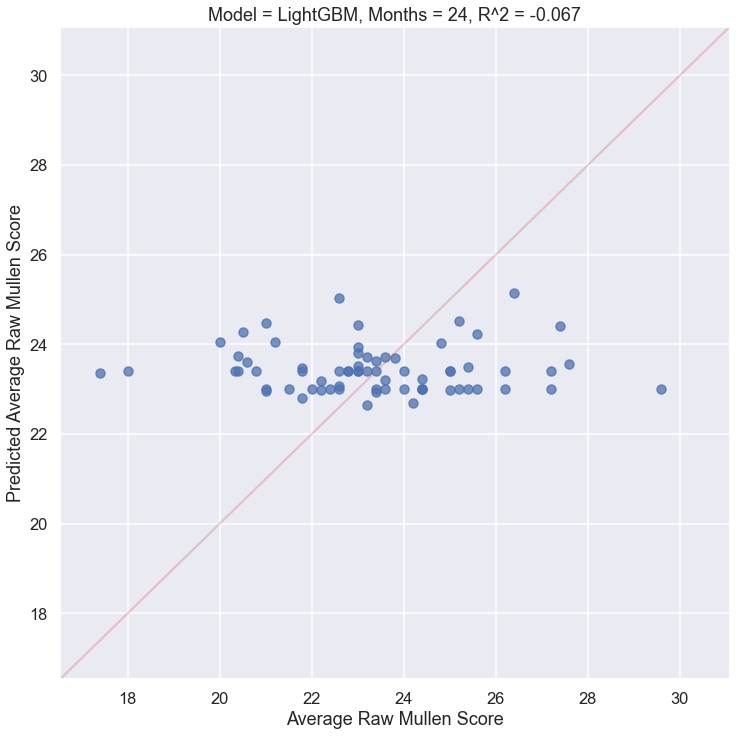

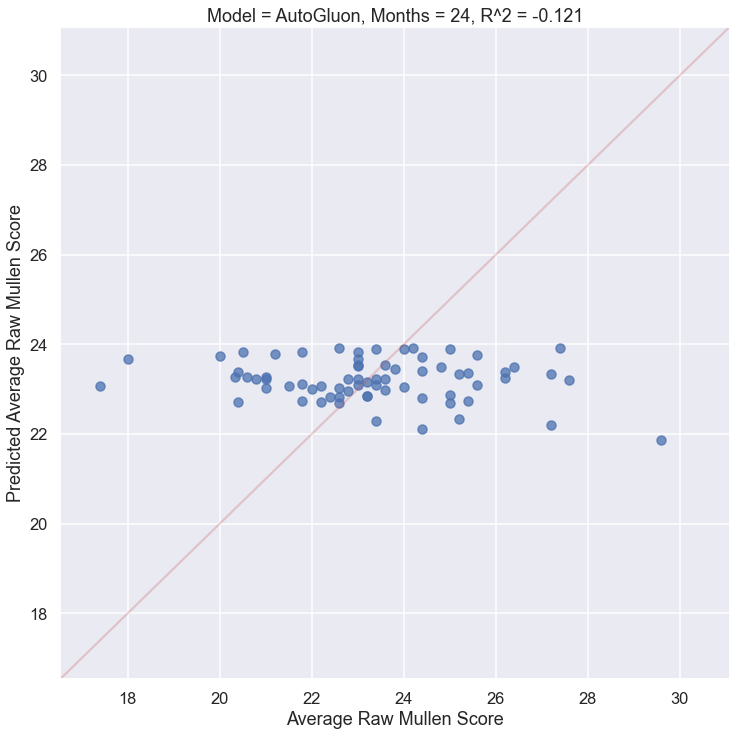

In [4]:
# plot scatter plots for 24m models
for model_name, results in raw_24m_results.items():
    y_est = get_held_outpredictions(X_24m, results['estimator'], raw_24m_outer_cv)
    plot_scatter(y_24m_raw, y_est, 24, model_name)

In [5]:
# OLS model on all of the data - 6M
model = sm.OLS(df_6m['mullen_6m_raw_average'], df_6m[input_covariates_6m])
results = model.fit()
print(results.summary())

                                  OLS Regression Results                                  
Dep. Variable:     mullen_6m_raw_average   R-squared (uncentered):                   0.998
Model:                               OLS   Adj. R-squared (uncentered):              0.996
Method:                    Least Squares   F-statistic:                              533.0
Date:                   Tue, 19 Jan 2021   Prob (F-statistic):                    3.02e-45
Time:                           15:51:29   Log-Likelihood:                         -41.002
No. Observations:                     78   AIC:                                      156.0
Df Residuals:                         41   BIC:                                      243.2
Df Model:                             37                                                  
Covariance Type:               nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----

In [6]:
# OLS model on all of the data - 24M
model = sm.OLS(df_24m['mullen_24m_raw_average'], df_24m[input_covariates_24m])
results = model.fit()
print(results.summary())

                                   OLS Regression Results                                  
Dep. Variable:     mullen_24m_raw_average   R-squared (uncentered):                   0.997
Model:                                OLS   Adj. R-squared (uncentered):              0.992
Method:                     Least Squares   F-statistic:                              246.4
Date:                    Tue, 19 Jan 2021   Prob (F-statistic):                    7.61e-31
Time:                            15:51:29   Log-Likelihood:                         -120.43
No. Observations:                      69   AIC:                                      314.9
Df Residuals:                          32   BIC:                                      397.5
Df Model:                              37                                                  
Covariance Type:                nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      